In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
# plt.rcParams['text.usetex'] = True  # Render Matplotlib text with Tex
from PIL import Image
from sklearn.model_selection import train_test_split
import time

import cv2

## Prepare data

In [2]:
# Define the data to be used
# DATASET = "../../datasets/dataset_to_delete/"
DATASET = "../../datasets/dataset_3+8bags_3var3sc_regression_classification_kmeans_split/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name)
        
        # Eventually apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]

        return image, traversal_cost, traversability_label

In [3]:
def compute_mean_std(images_directory, traversal_costs_file):
    transform = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
    ])
    
    # Create a Dataset for training
    dataset = TraversabilityDataset(
        traversal_costs_file=DATASET+traversal_costs_file,
        images_directory=DATASET+images_directory,
        transform=transform
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    cnt = 0
    first_moment = torch.empty(3)
    second_moment = torch.empty(3)

    for images, traversal_costs, traversability_labels in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        first_moment = (cnt * first_moment + sum_) / (cnt + nb_pixels)
        second_moment = (cnt * second_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean = first_moment
    std = torch.sqrt(second_moment - first_moment ** 2)
    
    return mean, std

In [4]:
mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
print(mean, std)

tensor([0.3426, 0.3569, 0.2914]) tensor([0.1363, 0.1248, 0.1302])


In [5]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])


# # Create a Dataset instance for our training data
# data = TraversabilityDataset(
#     traversal_costs_file=DATASET+"traversal_costs.csv",
#     images_directory=DATASET+"images",
#     transform=train_transform
# )

# # Split our training dataset into a training dataset and a validation dataset
# train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=train_transform
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=test_transform
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform=test_transform
)

# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


BATCH_SIZE = 32

# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [6]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [7]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (6239 samples)
15.0 % of the data for validation (1337 samples)
15.0 % of the data for testing (1338 samples)


## GPU?

In [8]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Model design and initialization

In [9]:
# Open TensorBoard
tensorboard = SummaryWriter()

# Load the pre-trained ResNet model
model = models.resnet18().to(device=device)

# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device=device)

# Replace the last layer by a fully-connected one with 1 output
model.fc = nn.Linear(model.fc.in_features, 1, device=device)

# Initialize the last layer using Xavier initialization
# nn.init.xavier_uniform_(model.fc.weight)

# Display the architecture in TensorBoard
images, traversal_costs, traversability_labels = next(iter(train_loader))
images = images.to(device)
tensorboard.add_graph(model, images)

# print(model)
# print(torchsummary.summary(model, (3, 100, 100)))

In [10]:
[(name, param.shape) for name, param in model.named_parameters()]

[('conv1.weight', torch.Size([64, 3, 7, 7])),
 ('bn1.weight', torch.Size([64])),
 ('bn1.bias', torch.Size([64])),
 ('layer1.0.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.0.bn1.weight', torch.Size([64])),
 ('layer1.0.bn1.bias', torch.Size([64])),
 ('layer1.0.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.0.bn2.weight', torch.Size([64])),
 ('layer1.0.bn2.bias', torch.Size([64])),
 ('layer1.1.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.1.bn1.weight', torch.Size([64])),
 ('layer1.1.bn1.bias', torch.Size([64])),
 ('layer1.1.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.1.bn2.weight', torch.Size([64])),
 ('layer1.1.bn2.bias', torch.Size([64])),
 ('layer2.0.conv1.weight', torch.Size([128, 64, 3, 3])),
 ('layer2.0.bn1.weight', torch.Size([128])),
 ('layer2.0.bn1.bias', torch.Size([128])),
 ('layer2.0.conv2.weight', torch.Size([128, 128, 3, 3])),
 ('layer2.0.bn2.weight', torch.Size([128])),
 ('layer2.0.bn2.bias', torch.Size([128])),
 ('layer2.0.downsample.0.we

In [11]:
print(model.fc.state_dict())

OrderedDict([('weight', tensor([[ 0.0226,  0.0154,  0.0006, -0.0336, -0.0419, -0.0103,  0.0350, -0.0052,
          0.0234,  0.0271, -0.0366,  0.0356, -0.0144,  0.0098, -0.0074, -0.0263,
          0.0221, -0.0346, -0.0349,  0.0204, -0.0366,  0.0214, -0.0131, -0.0412,
          0.0007,  0.0389,  0.0193,  0.0095,  0.0273, -0.0195, -0.0027, -0.0287,
          0.0333, -0.0219, -0.0064,  0.0401, -0.0175, -0.0411, -0.0089, -0.0364,
         -0.0264,  0.0411,  0.0037, -0.0225,  0.0349,  0.0024, -0.0224,  0.0428,
          0.0260,  0.0197, -0.0218,  0.0041, -0.0309, -0.0403, -0.0430,  0.0424,
          0.0385,  0.0040, -0.0117,  0.0258, -0.0407,  0.0210, -0.0303, -0.0211,
         -0.0396, -0.0160, -0.0379, -0.0076,  0.0323, -0.0156,  0.0105,  0.0308,
          0.0180,  0.0256, -0.0353, -0.0437,  0.0090, -0.0362, -0.0391,  0.0404,
         -0.0344,  0.0398, -0.0246, -0.0221,  0.0112, -0.0395,  0.0223, -0.0351,
         -0.0355, -0.0115,  0.0146, -0.0240, -0.0173, -0.0080, -0.0352, -0.0087,
    

## Training and validation loops

In [12]:
# Define the loss function
criterion = nn.MSELoss()

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["fc.weight", "fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.fc.parameters(), "lr": 1e-3},
],
    lr=1e-3, momentum=0.9, weight_decay=0.001)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 40

# Number of epochs we wait for the loss to decrease before stopping
# the training process early
patience = 10

best_val_loss = float('inf')
best_epoch = 0

loss_values = torch.zeros(2, NB_EPOCHS)

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, _ in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss 
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
    
    # Validation
    val_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, _ in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversal_costs = model(images)

            # Compute loss
            loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)

            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
    
    # Compute the losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    
    # Early stopping based on validation loss: stop the training if the
    # loss has not improved for the last 5 epochs
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     best_epoch = epoch
    
    # elif epoch - best_epoch >= patience:
    #     print(f'Early stopping at epoch {epoch}')
    #     break

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.14batch/s, batch_loss=0.0415]


Train loss:  0.17244895363274293
Validation loss:  0.056374091655015945


Epoch 1 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.42batch/s, batch_loss=0.12]  


Train loss:  0.07854181661819801
Validation loss:  0.06835880396621567


Epoch 2 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.85batch/s, batch_loss=0.0915]


Train loss:  0.075883321559582
Validation loss:  0.08482127751977671


Epoch 3 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.87batch/s, batch_loss=0.0307]


Train loss:  0.06593565782293295
Validation loss:  0.04984076086076952


Epoch 4 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.46batch/s, batch_loss=0.0447]


Train loss:  0.075062559134303
Validation loss:  0.07920582237697783


Epoch 5 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.28batch/s, batch_loss=0.0431]


Train loss:  0.06934344683511134
Validation loss:  0.08598668456432365


Epoch 6 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.22batch/s, batch_loss=0.0168]


Train loss:  0.06667611952393483
Validation loss:  0.04811844398223218


Epoch 7 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.30batch/s, batch_loss=0.097] 


Train loss:  0.07359157434831827
Validation loss:  0.10989539484892573


Epoch 8 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.73batch/s, batch_loss=0.0411]


Train loss:  0.06483407691121101
Validation loss:  0.05408673445206313


Epoch 9 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.64batch/s, batch_loss=0.0421]


Train loss:  0.0655332993524961
Validation loss:  0.04496893038352331


Epoch 10 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.28batch/s, batch_loss=0.0938]


Train loss:  0.07363440261628383
Validation loss:  0.06135563924908638


Epoch 11 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.63batch/s, batch_loss=0.085] 


Train loss:  0.060605205490421026
Validation loss:  0.09905921197718098


Epoch 12 [val]: 100%|██████████| 42/42 [00:01<00:00, 38.33batch/s, batch_loss=0.0493]


Train loss:  0.06546349618106316
Validation loss:  0.052901123295582476


Epoch 13 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.27batch/s, batch_loss=0.088] 


Train loss:  0.06363766176196245
Validation loss:  0.0735162685492209


Epoch 14 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.96batch/s, batch_loss=0.0525]


Train loss:  0.062481153211914574
Validation loss:  0.04831742548516819


Epoch 15 [val]: 100%|██████████| 42/42 [00:01<00:00, 38.66batch/s, batch_loss=0.0498]


Train loss:  0.06000256223174242
Validation loss:  0.053803536020928903


Epoch 16 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.95batch/s, batch_loss=0.0363]


Train loss:  0.05973614431822147
Validation loss:  0.048376349155746755


Epoch 17 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.96batch/s, batch_loss=0.0248]


Train loss:  0.06213371648620337
Validation loss:  0.04793091426559147


Epoch 18 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.99batch/s, batch_loss=0.0217]


Train loss:  0.059487947267599595
Validation loss:  0.047643868651773245


Epoch 19 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.35batch/s, batch_loss=0.0355]


Train loss:  0.059436252350226426
Validation loss:  0.04913895461885702


Epoch 20 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.36batch/s, batch_loss=0.0226]


Train loss:  0.05576402501991162
Validation loss:  0.047317992008867715


Epoch 21 [val]: 100%|██████████| 42/42 [00:01<00:00, 30.42batch/s, batch_loss=0.0258]


Train loss:  0.06008294274409612
Validation loss:  0.04832354587103639


Epoch 22 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.50batch/s, batch_loss=0.0343]


Train loss:  0.056138276366087106
Validation loss:  0.04736624511757067


Epoch 23 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.98batch/s, batch_loss=0.0899]


Train loss:  0.0553625066119891
Validation loss:  0.05619329617669185


Epoch 24 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.65batch/s, batch_loss=0.0261]


Train loss:  0.056642173861081786
Validation loss:  0.04424918274439517


Epoch 25 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.44batch/s, batch_loss=0.0285]


Train loss:  0.05480643534220946
Validation loss:  0.04542584256047294


Epoch 26 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.34batch/s, batch_loss=0.049] 


Train loss:  0.056861833435220596
Validation loss:  0.0439335930471619


Epoch 27 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.86batch/s, batch_loss=0.0606]


Train loss:  0.05825221371383239
Validation loss:  0.05371739466985067


Epoch 28 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.68batch/s, batch_loss=0.0393]


Train loss:  0.054982679948592794
Validation loss:  0.05007976129473675


Epoch 29 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.56batch/s, batch_loss=0.0361]


Train loss:  0.0529451001339998
Validation loss:  0.052692386942605175


Epoch 30 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.68batch/s, batch_loss=0.0366]


Train loss:  0.05516285625978922
Validation loss:  0.047685573232315835


Epoch 31 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.68batch/s, batch_loss=0.0914]


Train loss:  0.05477526295834627
Validation loss:  0.0458101157897285


Epoch 32 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.91batch/s, batch_loss=0.0296]


Train loss:  0.0602388396859169
Validation loss:  0.050198648169281934


Epoch 33 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.41batch/s, batch_loss=0.0836]


Train loss:  0.05135413581171097
Validation loss:  0.04584053651030574


Epoch 34 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.70batch/s, batch_loss=0.0769]


Train loss:  0.05210267606262977
Validation loss:  0.047561846407396455


Epoch 35 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.13batch/s, batch_loss=0.0556]


Train loss:  0.054266001030993764
Validation loss:  0.045119538415400756


Epoch 36 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.76batch/s, batch_loss=0.0302]


Train loss:  0.0524399757767335
Validation loss:  0.04624568529072262


Epoch 37 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.12batch/s, batch_loss=0.0849]


Train loss:  0.05198671091825534
Validation loss:  0.06439466020535856


Epoch 38 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.49batch/s, batch_loss=0.0446]


Train loss:  0.05009745909139896
Validation loss:  0.041842694549510874


Epoch 39 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.18batch/s, batch_loss=0.0609]

Train loss:  0.05172068709746385
Validation loss:  0.06060402818201553


### Visualization

Text(0.5, 0, 'Epoch')

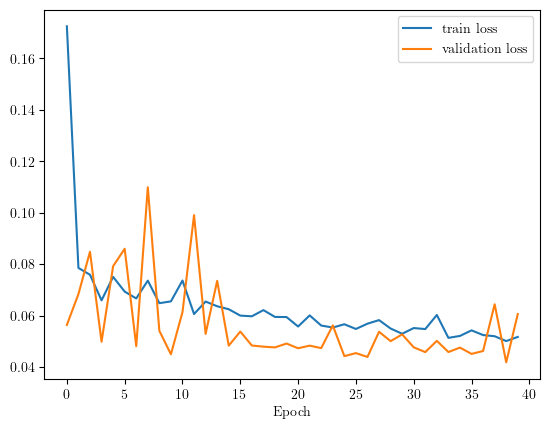

In [13]:
# Loss
indices = loss_values[0] != 0
train_losses = loss_values[0][indices]
val_losses = loss_values[1][indices]

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [14]:
# Testing
test_loss = 0.

# Configure the model for testing
model.eval()

with torch.no_grad():
    # Loop over the testing batches
    for images, traversal_costs, _ in test_loader:
        
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Accumulate batch loss to average of the entire testing set
        test_loss += loss.item()
        
# Compute the loss and accuracy
test_loss /= len(test_loader)

print("Test loss: ", test_loss)

Test loss:  0.059557005698024135


In [41]:
images, traversal_costs, _ = next(iter(test_loader))

images = images.to(device)
traversal_costs = traversal_costs.to(device)

predicted_traversal_scores = model(images)
# predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

print("Output:\n", predicted_traversal_costs)
print("Ground truth:\n", traversal_costs)

# print(predicted_traversal_scores-traversal_scores)

# predicted_traversal_scores = predicted_traversal_scores.to("cpu").detach().numpy()
# plt.hist(predicted_traversal_scores)


Output:
 tensor([[2.0622],
        [1.4585],
        [1.9043],
        [2.1624],
        [1.9757],
        [2.0722],
        [1.9546],
        [1.9779],
        [1.9246],
        [1.9387],
        [1.9201],
        [1.6849],
        [1.8691],
        [2.0227],
        [1.7642],
        [1.9321],
        [1.6783],
        [2.1785],
        [2.1655],
        [1.3817],
        [1.9115],
        [1.6339],
        [1.7190],
        [1.8927],
        [1.9418],
        [1.6963]], device='cuda:0')
Ground truth:
 tensor([1.4431, 1.8142, 1.4213, 1.8988, 1.6864, 1.0896, 1.3164, 1.1830, 1.9168,
        1.0740, 1.7578, 1.9497, 1.1054, 1.4927, 2.1730, 1.6349, 1.9143, 1.6020,
        1.8331, 2.0072, 1.7344, 1.1041, 1.8847, 1.4045, 0.9980, 2.2835, 1.8514,
        1.1247, 2.0487, 1.2955, 1.9082, 1.9524], device='cuda:0',
       dtype=torch.float64)


(array([  58.,  323.,  565.,  727.,  665.,  921., 1330., 1083.,  458.,
         109.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

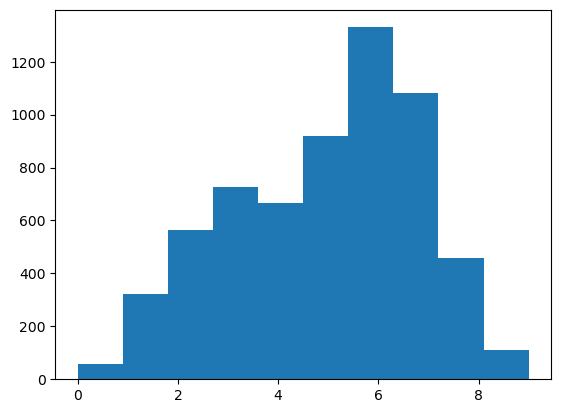

In [74]:
traversal_costs_train = []

for _, score in train_set:
    traversal_costs_train.append(score)
    
# print(traversal_scores_train)
plt.hist(traversal_costs_train, bins=10)

## Save model parameters

In [ ]:
# Save the model parameters
torch.save(model.state_dict(), "resnet18_fine_tuned_3+8bags_3var3sc_classification_kmeans_100epochs.params")